# Алгоритм имитации

In [1]:
import numpy as np
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

from math import cos, pi, sin, sqrt
from scipy.signal import periodogram

In [2]:
%matplotlib inline

## Вспомогательные функции

### Для аналитического задания сигналов

In [3]:
def sinc(x):
	if x:
		return sin(x) / x
	else:
		return 1

### Для преобразований

In [4]:
def build_density(counts):
	'''
	Построение ФСПМ по значениям отсчетов
	
	:param counts: 
	:return:
	 
	'''
	
	def s(k):
		return counts[k]
	
	return s


def fourier_transform(x):
	'''
	Прямое ДПФ
	
	:param x: 
	:return: 
	
	'''
	
	N = len(x)
	
	spectrum = []
	
	spectrum += [(1 / N) * sum(x)]
	
	lambdas = list()
	
	for k in range(1, N // 2):
		X_e = 2 / N * sum(x * cos(2 * pi * k * i / N) for i, x in enumerate(x))
		X_o = 2 / N * sum(x * sin(2 * pi * k * i / N) for i, x in enumerate(x))
		
		spectrum += [X_e, X_o]
		
		lambdas += [X_o / X_e]
		
	spectrum += [(1 / N) * sum(x * cos(pi * i) for i, x in enumerate(x))]
	
	return spectrum, lambdas


def back_fourier_transform(x, N, multiple=1.):
	'''
	Обратное ДПФ
	
	:param x: 
	:param N: 
	:param multiple: 
	:return: 
	
	'''
	
	X_0, X_N = x[0], x[-1]
	X_e, X_o = x[1:-1:2], x[2:-1:2]
	
	signal = [X_0 + multiple * sum(X_e * cos(2 * pi * i * k / N)
	                               + X_o * sin(2 * pi * i * k / N)
	                               for k, X_e, X_o in zip(range(1, N // 2), X_e, X_o))
	          + X_N * cos(pi * i) for i in range(N)]
	
	return signal


def autocorrelate(x):
	'''
	Расчет АКФ
	
	:param x: 
	:return: 
	
	'''
	
	result = np.correlate(x, x, mode='full')
	return result[result.size // 2:]

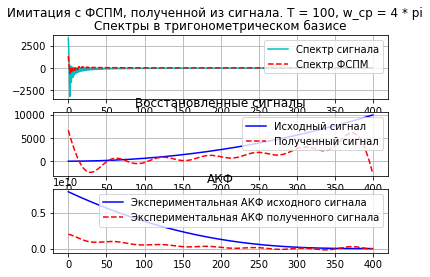

In [5]:
T = 100
w_h = 4 * pi

delta_t = pi / w_h

N = int(T / delta_t)

x = np.random.normal(0, 1, N)
x = [x ** 2 for x in np.arange(0, T, delta_t)]

f, P = periodogram(x, w_h)

S = build_density(P[1:])

spec, lambdas = fourier_transform(x)

estimated_spec = []

estimated_spec += [sqrt(S(0) / T)]

for k, l in enumerate(lambdas):
	X_e = sqrt(S(k + 1) / (T * (1 + l ** 2)))
	X_o = l * X_e
	
	estimated_spec += [X_e, X_o]

# Погрешность может быть тут из-за того, что мы берем последний (уже использованный) элемент S!!!
estimated_spec += [sqrt(S(N // 2 - 1) / (T * (1 + lambdas[-1] ** 2)))]

fig = plt.figure()

fig.suptitle('Имитация с ФСПМ, полученной из сигнала. T = 100, w_cp = 4 * pi')

ax = fig.add_subplot(311)
ax.set_title('Спектры в тригонометрическом базисе')
ax1, = ax.plot(spec, 'c', label='Спектр сигнала')
ax2, = ax.plot(estimated_spec, 'r--', label='Спектр ФСПМ')

ax.legend(handles=[ax1, ax2], loc=1)

ax.grid('on')

# Множитель 2,5 дает совпадение АКФ.
imitated = back_fourier_transform(estimated_spec, N, 2.5)

ax = fig.add_subplot(312)
ax.set_title('Восстановленные сигналы')
ax1, = ax.plot(x, 'b', label='Исходный сигнал')
ax2, = ax.plot(imitated, 'r--', label='Полученный сигнал')

ax.legend(handles=[ax1, ax2], loc=1)

ax.grid('on')

ax = fig.add_subplot(313)
ax.set_title('АКФ')
ax1, = ax.plot(autocorrelate(x), 'b', label='Экспериментальная АКФ исходного сигнала')
ax2, = ax.plot(autocorrelate(imitated), 'r--', label='Экспериментальная АКФ полученного сигнала')

ax.legend(handles=[ax1, ax2], loc=1)

ax.grid('on')

plt.show()

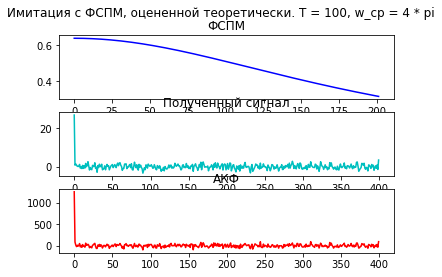

In [6]:
T = 100
w_h = 4 * pi

delta_t = pi / w_h
delta_w = 2 * pi / T

N = int(T / delta_t)

S = lambda w: [0, 4 * pi / (w_h * T)][abs(w) <= w_h]

S = lambda w: [0, 1 - w / w_h][abs(w) < w_h]

S = lambda w: (2 * 4 / w_h) * (1 / (1 + (w / w_h) ** 2))

lambdas = np.random.normal(0, 1, N // 2)

estimated_spec = []

estimated_spec += [sqrt(S(0) / T)]

for k, l in enumerate(lambdas):
	X_e = sqrt(S(k * delta_w) / (T * (1 + l ** 2)))
	X_o = l * X_e
	
	estimated_spec += [X_e, X_o]

estimated_spec += [sqrt(S(pi / delta_t) / (T * (1 + lambdas[-1] ** 2)))]

imitated = back_fourier_transform(estimated_spec, N, 2.5)

fig = plt.figure()

fig.suptitle('Имитация с ФСПМ, оцененной теоретически. T = 100, w_cp = 4 * pi')

ax = fig.add_subplot(311)
ax.set_title('ФСПМ')
ax.plot([S(w) for w in np.arange(0, w_h + 2 * delta_w, delta_w)], 'b')

ax = fig.add_subplot(312)
ax.set_title('Полученный сигнал')
ax.plot(imitated, 'c')

ax = fig.add_subplot(313)
ax.set_title('АКФ')
ax.plot(autocorrelate(imitated), 'r')
	
plt.show()